## TMA4215 Numerical Mathematics
### Project: Numerical Integrators for Charged Particles

#### Project members:
- Julian Tomasso Christensen Fredriksen
- Jonathan Lundstedt

# Problem A

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System 1: 2D charged particle

def B1(x):
    c = np.sqrt(x[0]**2 + x[1]**2)
    return np.array([0.0, 0.0, c])

def A1(x):
    r = np.sqrt(x[0]**2 + x[1]**2)
    a = -x[1] * r
    b =  x[0] * r
    return np.array([a/3.0, b/3.0, 0.0])

def U1(x):
    r = np.hypot(x[0], x[1])
    if r == 0.0:
        return 0.0
    return 1.0/(100.0*r)

def grad_U1(x):
    r2 = x[0]**2 + x[1]**2
    if r2 == 0.0:
        return np.zeros(3)
    ab = (r2)**(-3/2)
    k = -1.0/100.0
    return np.array([k * x[0] * ab, k * x[1] * ab, 0.0])

x0_1 = np.array([0.0, 1.0, 0.1])
v0_1 = np.array([0.09, 0.05, 0.20])


In [72]:
# System 2: Tokamak magnetic field

def B2(x):
    r2 = x[0]**2 + x[1]**2
    if r2 < 1e-14:
        r2 = 1e-14
    a = -(2*x[1] + x[0]*x[2]) / (2*r2)
    b =  (2*x[0] - x[1]*x[2]) / (2*r2)
    c =  (np.sqrt(r2) - 1.0) / (2.0*np.sqrt(r2))
    return np.array([a, b, c])

def A2(x):
    k = 0.5
    x0, x1, x2 = float(x[0]), float(x[1]), float(x[2])
    r = np.hypot(x0, x1)
    if r < 1e-12:
        r = 1e-12
    b = x0 - np.log(r + x0)
    c = x2 * np.arctan2(x1, x0) + np.log(x0**2 + x1**2)
    return np.array([0.0, k*b, -k*c])

def U2(x):
    return 0.0

def grad_U2(x):
    return np.array([0.0, 0.0, 0.0])

x0_2 = np.array([1.2, 0.0, 0.0])
v0_2 = np.array([0.0, 4.816e-4, -2.059e-3])


In [73]:
def lorentz_rhs(t, y, B, grad_U):
    """
    RHS of the first-order system:
    """
    x = y[:3]
    v = y[3:]
    dxdt = v
    dvdt = np.cross(v, B(x)) - grad_U(x)
    return np.concatenate((dxdt, dvdt))

# Defining rk4_step to use it in the Boris and RK4 method
def rk4_step(x, v, h, B, grad_U):
    """
    One RK4 step
    """
    def f(x, v):
        return np.cross(v, B(x)) - grad_U(x)

    kv1 = h * f(x, v)
    kx1 = h * v

    kv2 = h * f(x + 0.5 * kx1, v + 0.5 * kv1)
    kx2 = h * (v + 0.5 * kv1)

    kv3 = h * f(x + 0.5 * kx2, v + 0.5 * kv2)
    kx3 = h * (v + 0.5 * kv2)

    kv4 = h * f(x + kx3, v + kv3)
    kx4 = h * (v + kv3)

    v_new = v + (kv1 + 2*kv2 + 2*kv3 + kv4) / 6.0
    x_new = x + (kx1 + 2*kx2 + 2*kx3 + kx4) / 6.0
    return x_new, v_new

In [74]:
# 1) Boris method

def boris_step(xn, v_half_prev, h, B, grad_U):
    """
    One Boris step
    """
    E = -grad_U(xn)
    Bn = B(xn)

    v_minus = v_half_prev + 0.5 * h * E

    t = 0.5 * h * Bn
    t2 = np.dot(t, t)
    s = 2.0 * t / (1.0 + t2)

    v_prime = v_minus + np.cross(v_minus, t)
    v_plus  = v_minus + np.cross(v_prime, s)

    v_half_next = v_plus + 0.5 * h * E

    x_next = xn + h * v_half_next

    return x_next, v_half_next


def boris_integrate(x0, v0, h, n_steps, B, grad_U):
    """
    Integrate with the Boris method.
    """
    xs = np.zeros((n_steps + 1, 3))
    v_half = np.zeros((n_steps + 1, 3))

    xs[0] = x0

    # Approximate v(-1/2) by one RK4 half-step backwards from (x0, v0)
    x_back, v_back = rk4_step(x0, v0, -0.5 * h, B, grad_U)
    v_half[0] = v_back

    for n in range(n_steps):
        x_next, v_half_next = boris_step(xs[n], v_half[n], h, B, grad_U)
        xs[n+1] = x_next
        v_half[n+1] = v_half_next

    # Recover v(n) at integer times by averaging
    vs = np.zeros_like(xs)
    vs[0] = v0
    for n in range(1, n_steps):
        vs[n] = 0.5 * (v_half[n] + v_half[n-1])
    # For the last point, just reuse the previous average
    vs[-1] = 0.5 * (v_half[-1] + v_half[-2])

    return xs, vs




In [75]:
# 2) RK4 method

def rk4_integrate(x0, v0, h, n_steps, B, grad_U):
    """
    Integrate with the RK4 method
    """
    xs = np.zeros((n_steps + 1, 3))
    vs = np.zeros((n_steps + 1, 3))

    xs[0] = x0
    vs[0] = v0

    for n in range(n_steps):
        x_new, v_new = rk4_step(xs[n], vs[n], h, B, grad_U)
        xs[n+1] = x_new
        vs[n+1] = v_new

    return xs, vs

In [76]:
# 3) Fourth-order symmetric multistep method

# Coefficients
a1, a2, a3 = -0.7, 0.1, 0.9

beta0 = (20*a1*a2*a3 - 4*(a1*a2 + a1*a3 + a2*a3) - 28*(a1 + a2 + a3) - 52) / 3.0
beta1 = (2*a1*a2*a3 + 14*(a1*a2 + a1*a3 + a2*a3) + 26*(a1 + a2 + a3) + 38) / 3.0

alpha = np.array([
    1.0,
    -7/5,
    9/25,
    22/125,
    -34/125,
    22/125,
    9/25,
    -7/5,
    1.0
])


def numerical_jacobian_A(A, x, eps=1e-6):
    """
    Approximation of the Jacobian A'(x).
    """
    x = np.asarray(x, dtype=float)
    J = np.zeros((3, 3), dtype=float)
    f0 = A(x)
    for j in range(3):
        dx = np.zeros(3)
        dx[j] = eps
        f_plus  = A(x + dx)
        f_minus = A(x - dx)
        J[:, j] = (f_plus - f_minus) / (2.0 * eps)
    return J


def five_point_delta(vecs, j):
    """
    Five-point central difference:
    """
    return (vecs[j-2] - 8*vecs[j-1] + 8*vecs[j+1] - vecs[j+2]) / 12.0


def symmetric_step_block(X8, h, A, grad_U, A_jac=None):
    """
    One step with the multistep method.
    """
    if A_jac is None:
        def A_jac_fun(x):
            return numerical_jacobian_A(A, x)
    else:
        A_jac_fun = A_jac

    # We treat indices relative to the block:
    # X8[0] = x_{n-4}, ..., X8[7] = x_{n+3}
    # F_{n-1} -> j = n-1 -> local index 3
    # F_n     -> j = n   -> local index 4
    # F_{n+1} -> j = n+1 -> local index 5

    X = X8

    def compute_F(local_idx):
        # Compute v_j = Δx_j / h
        v_j = five_point_delta(X, local_idx) / h

        # AΔ_j = ΔA(x_j) / h
        A_vals = np.array([A(X[k]) for k in range(8)])
        A_delta_j = five_point_delta(A_vals, local_idx) / h

        # F_j = A'(x_j)^T v_j - AΔ_j - grad_U(x_j)
        xj = X[local_idx]
        J = A_jac_fun(xj)  # 3x3
        term1 = J.T @ v_j
        F_j = term1 - A_delta_j - grad_U(xj)
        return F_j

    F_nm1 = compute_F(3)
    F_n   = compute_F(4)
    F_np1 = compute_F(5)

    RHS_F = h**2 * (beta1 * F_nm1 + beta0 * F_n + beta1 * F_np1)

    # Sum over j = -4,...,3 of α_j x_{n+j}
    # α indices: α[0] -> j=-4, ..., α[7] -> j=3
    sum_alpha_x = np.zeros(3)
    for k in range(8):  # 0..7
        sum_alpha_x += alpha[k] * X[k]

    # Solve for x_{n+4}:
    alpha4 = alpha[8]  # coefficient for j=4
    x_np4 = (RHS_F - sum_alpha_x) / alpha4

    return x_np4


def symmetric_multistep_integrate(x0, v0, h, n_steps, A, grad_U, B, A_jac=None):
    """
    Integrate with the multistep method
    Use solve_ivp (RK45) on the system to generate 
    x(0),...,x(7). Then apply the multistep formula repeatedly to advance beyond t_7.
    """
    # Step 1: startup for x_0..x_7
    T_start = 7 * h
    t_eval = np.linspace(0.0, T_start, 8)  # 0..7

    y0 = np.concatenate((x0, v0))
    sol = solve_ivp(
        lorentz_rhs,
        t_span=(0.0, T_start),
        y0=y0,
        t_eval=t_eval,
        rtol=1e-10,
        atol=1e-12,
        args=(B, grad_U)
    )

    xs_all = [sol.y[:3, i] for i in range(sol.y.shape[1])]  # x_0..x_7
    xs_all = [np.array(x) for x in xs_all]

    # If we only need up to 7, we stop early
    if n_steps <= 7:
        return np.array(xs_all[:n_steps+1])

    # Step 2: multistep for k >= 8
    current_index = 7
    while current_index < n_steps:
        # We need the last 8 points: x_{n-4..n+3}
        # For the first step with n=4, those are x_0..x_7
        # In general, when current_index = n+3, last 8 indices are current_index-7..current_index
        X8 = np.array(xs_all[current_index-7: current_index+1])  # shape (8,3)
        x_new = symmetric_step_block(X8, h, A, grad_U, A_jac=A_jac)
        xs_all.append(x_new)
        current_index += 1

    xs_all = np.array(xs_all[:n_steps+1])
    return xs_all

In [77]:
T = 10**5
h = 0.1
N = int(T / h)
print(f'Number of steps: {N}')

Number of steps: 1000000


In [78]:
# 2D charged particle
xs_boris_1, vs_boris_1 = boris_integrate(x0_1, v0_1, h, N, B1, grad_U1)
xs_rk4_1, vs_rk4_1 = rk4_integrate(x0_1, v0_1, h, N, B1, grad_U1)
xs_sym_1 = symmetric_multistep_integrate(x0_1, v0_1, h, N, A1, grad_U1, B1)


In [79]:
# Tokamak magnetic field
xs_boris_2, vs_boris_2 = boris_integrate(x0_2, v0_2, h, N, B2, grad_U2)
xs_rk4_2, vs_rk4_2 = rk4_integrate(x0_2, v0_2, h, N, B2, grad_U2)
xs_sym_2 = symmetric_multistep_integrate(x0_2, v0_2, h, N, A2, grad_U2, B2)


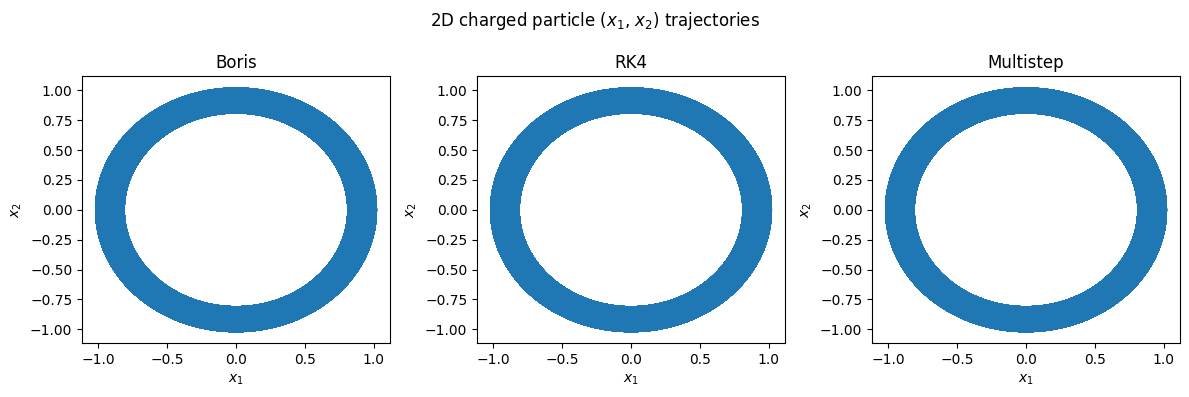

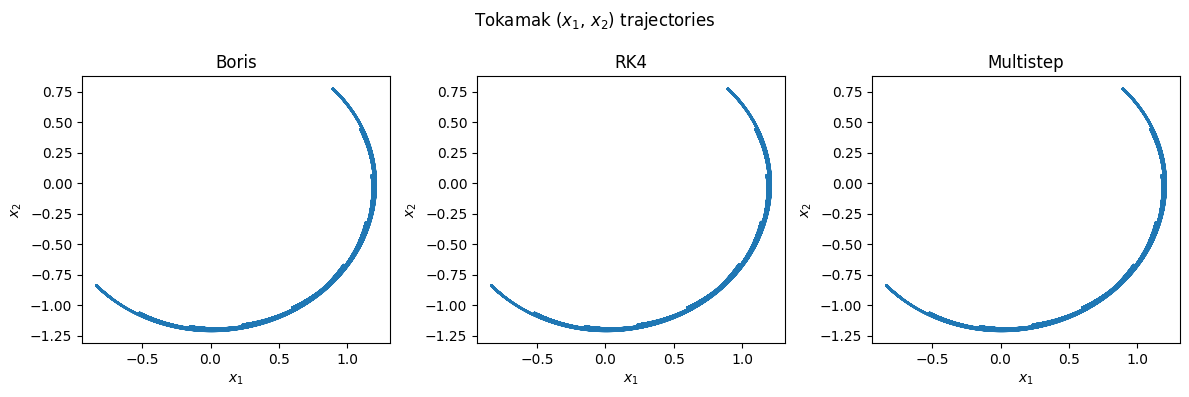

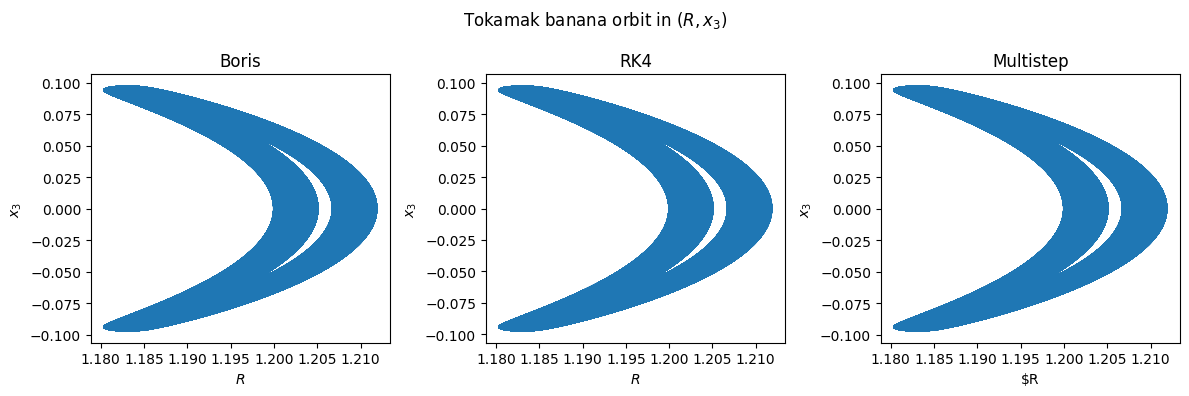

In [80]:
# 2D charged particle (x1, x2) trajectories
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Boris
axes[0].plot(xs_boris_1[:, 0], xs_boris_1[:, 1])
axes[0].set_title("Boris")
axes[0].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")

# RK4
axes[1].plot(xs_rk4_1[:, 0],   xs_rk4_1[:, 1])
axes[1].set_title("RK4")
axes[1].set_xlabel(r"$x_1$")
axes[1].set_ylabel(r"$x_2$")

# Multistep 
axes[2].plot(xs_sym_1[:, 0],   xs_sym_1[:, 1])
axes[2].set_title("Multistep")
axes[2].set_xlabel(r"$x_1$")
axes[2].set_ylabel(r"$x_2$")

fig.suptitle("2D charged particle ($x_1$, $x_2$) trajectories")
plt.tight_layout()
plt.show()

# Tokamak (x1, x2) Trajectories
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Boris
axes[0].plot(xs_boris_2[:, 0], xs_boris_2[:, 1])
axes[0].set_title("Boris")
axes[0].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")

# RK4
axes[1].plot(xs_rk4_2[:, 0],   xs_rk4_2[:, 1])
axes[1].set_title("RK4")
axes[1].set_xlabel(r"$x_1$")
axes[1].set_ylabel(r"$x_2$")

# Multistep
axes[2].plot(xs_sym_2[:, 0],   xs_sym_2[:, 1])
axes[2].set_title("Multistep")
axes[2].set_xlabel(r"$x_1$")
axes[2].set_ylabel(r"$x_2$")

fig.suptitle("Tokamak ($x_1$, $x_2$) trajectories")
plt.tight_layout()
plt.show()

# Tokamak: banana orbit in $(R,x_3)$

R_boris_2 = np.sqrt(xs_boris_2[:, 0]**2 + xs_boris_2[:, 1]**2)
R_rk4_2 = np.sqrt(xs_rk4_2[:, 0]**2   + xs_rk4_2[:, 1]**2)
R_sym_2 = np.sqrt(xs_sym_2[:, 0]**2   + xs_sym_2[:, 1]**2)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Boris
axes[0].plot(R_boris_2, xs_boris_2[:, 2])
axes[0].set_title("Boris")
axes[0].set_xlabel(r"$R$")
axes[0].set_ylabel(r"$x_3$")

# RK4
axes[1].plot(R_rk4_2,   xs_rk4_2[:, 2])
axes[1].set_title("RK4")
axes[1].set_xlabel(r"$R$")
axes[1].set_ylabel(r"$x_3$")

# Multistep
axes[2].plot(R_sym_2,   xs_sym_2[:, 2])
axes[2].set_title("Multistep")
axes[2].set_xlabel(r"$R")
axes[2].set_ylabel(r"$x_3$")

fig.suptitle("Tokamak banana orbit in $(R,x_3)$")
plt.tight_layout()
plt.show()


# Problem A 1.

#### 2D charged particle - trajectories
The top row shows the particle trajectories in the $(x_1, x_2)$-plane.  
All three methods, **Boris**, **RK4**, and **Multistep**, produce nearly identical circular orbits.  
This is the expected behaviour for this magnetic field, where the Lorentz force generates a stable gyro-motion with approximately constant radius.  

No visible drift or deformation appears over the simulated time interval, indicating that the step size $h = 0.1$ is sufficiently small for all schemes.

#### Tokamak magnetic field - trajectories
The lower plots show the particle motion in the tokamak magnetic field.  
The $(x_1, x_2)$-projection displays a "thin half moon", while the $(R, x_3)$-projection clearly reproduces the characteristic *banana orbit* shown in **Figure 6 of He et al. (2015)**.  
This indicates that the particle experiences magnetic mirror effects and remains confined between two turning points in the poloidal direction, which is the expected behaviour in an axisymmetric tokamak geometry.

All three methods yield virtually identical trajectories, with no noticeable drift or distortion.  
This is consistent with theory; for the chosen step size and the relatively short simulation horizon, **RK4** remains accurate, while the long-term advantages of geometric integrators (bounded energy and momentum errors over very long times) would only become visible for much longer integrations.


In [81]:
def compute_reference_solution(x0, v0, B, grad_U, T, h, rtol=1e-12, atol=1e-12):
    """
    Reference solution using solve_ivp (RK45)
    """
    N = int(T/h)
    t_grid = np.linspace(0.0, T, N+1)
    y0 = np.concatenate((x0, v0))
    sol = solve_ivp(
        lorentz_rhs,
        t_span=(0.0, T),
        y0=y0,
        t_eval=t_grid,
        rtol=rtol,
        atol=atol,
        args=(B, grad_U)
    )
    x_ref = sol.y[:3, :].T
    v_ref = sol.y[3:, :].T
    return t_grid, x_ref, v_ref


In [82]:
# 2D charged particle
# Reference solution
t1, xref1, vref1 = compute_reference_solution(x0_1, v0_1, B1, grad_U1, T, h)

In [83]:
# Tokamak magnetic field
# Reference solution
t2, xref2, vref2 = compute_reference_solution(x0_2, v0_2, B2, grad_U2, T, h)

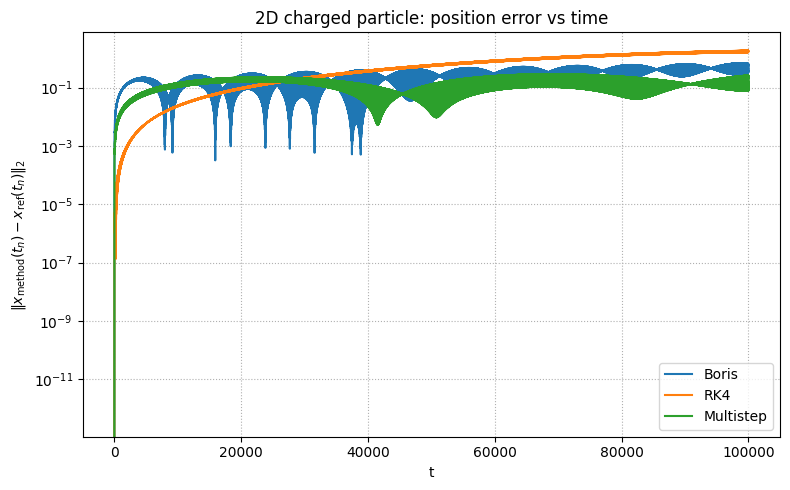

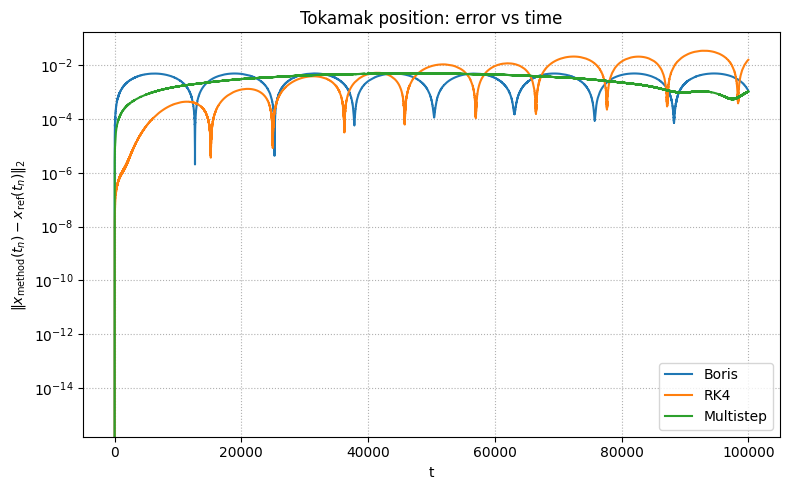

In [84]:
err_boris_1 = np.linalg.norm(xs_boris_1 - xref1, axis=1)
err_rk4_1 = np.linalg.norm(xs_rk4_1 - xref1, axis=1)
err_sym_1 = np.linalg.norm(xs_sym_1 - xref1, axis=1)

plt.figure(figsize=(8, 5))
plt.semilogy(t1, err_boris_1, label="Boris")
plt.semilogy(t1, err_rk4_1, label="RK4")
plt.semilogy(t1, err_sym_1, label="Multistep")
plt.xlabel("t")
plt.ylabel(r"$\|x_{\mathrm{method}}(t_n) - x_{\mathrm{ref}}(t_n)\|_2$")
plt.title("2D charged particle: position error vs time")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

err_boris_2 = np.linalg.norm(xs_boris_2 - xref2, axis=1)
err_rk4_2 = np.linalg.norm(xs_rk4_2 - xref2, axis=1)
err_sym_2 = np.linalg.norm(xs_sym_2 - xref2, axis=1)

plt.figure(figsize=(8, 5))
plt.semilogy(t2, err_boris_2, label="Boris")
plt.semilogy(t2, err_rk4_2, label="RK4")
plt.semilogy(t2, err_sym_2, label="Multistep")
plt.xlabel("t")
plt.ylabel(r"$\|x_{\mathrm{method}}(t_n) - x_{\mathrm{ref}}(t_n)\|_2$")
plt.title("Tokamak position: error vs time")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


# Problem A 2.
#### 2D charged particle - position error  
The plot shows how the position error develops over time for the three methods.  
Although all methods remain stable, their long-time behaviour is quite different.

- The **RK4** method starts out with a tiny error, which is expected for a classical fourth-order method.  
  However, as time goes on the error grows steadily, and by the end of the simulation **RK4** actually has the largest error of the three.  
  This happens because **RK4** is not a geometric integrator, so its small local errors accumulate over very long time intervals.

- The **Boris** method has a larger initial error, but it stays relatively bounded and shows the characteristic oscillatory pattern of volume-preserving, time-reversible schemes. We still see a minimal increase in error over time, but it is smaller than the **RK4** method. 

- The **Multistep** method also settles into a bounded error that only oscillates mildly after the initial transient.
  This behaviour is typical for symmetric multistep methods; they do not minimize the short-term error, but they do control long-term drift very effectively.
  This method ends up with the smallest error. 

#### Tokamak magnetic field – position error  

- The **RK4** method initially has a small error, but its error begins to oscillate increasingly over time.  
  In this system the particle exhibits fast gyro-motion and slow toroidal drift.  
  Because **RK4** is not geometric, it introduces small phase errors in both motions, and these phase errors interfere.  
  This produces the oscillatory pattern in the error curve.  
  The **RK4** error grows gradually, and by the end of the simulation **RK4** has the largest error.

- The **Boris** method also oscillates, but for a different reason: it is a volume-preserving, time-reversible geometric method.  
  Geometric integrators do not accumulate error monotonically; instead the error typically oscillates around a bounded range.  
  The repeated sharp drops in error (several orders of magnitude) are characteristic of this behaviour.

- The **Multistep** method displays mild, geometry-induced oscillations in the global error, although these are much smaller and less frequent than for the other methods. After a short transient, the error settles into an almost flat plateau with only tiny fluctuations.  
This behaviour is fully consistent with the theory of symmetric multistep methods: due to *s-stability*, the parasitic modes described by *Hairer & Lubich (Sections 6–7)* remain bounded with very small amplitude, and the method preserves a modified energy without long-term drift.  


In [85]:
def energy(xs, vs, U):
    """
    Compute E(x,v) = 0.5 ||v||^2 + U(x)
    """
    v2 = np.sum(vs*vs, axis=1)
    E = 0.5 * v2 + np.array([U(x) for x in xs])
    return E


def estimate_velocities_from_positions(xs, h):
    """
    Estimate of v from x(t)
    """
    xs = np.asarray(xs)
    N = xs.shape[0] - 1
    vs = np.zeros_like(xs)
    vs[1:N] = (xs[2:] - xs[:-2]) / (2*h)
    vs[0] = (xs[1] - xs[0]) / h
    vs[N] = (xs[N] - xs[N-1]) / h
    return vs


In [86]:
vs_sym_1 = estimate_velocities_from_positions(xs_sym_1, h)
vs_sym_2 = estimate_velocities_from_positions(xs_sym_2, h)

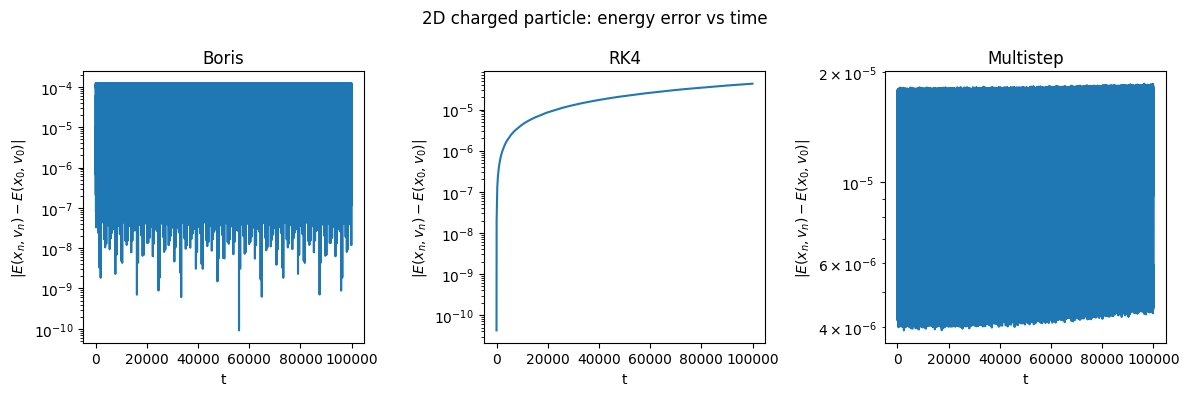

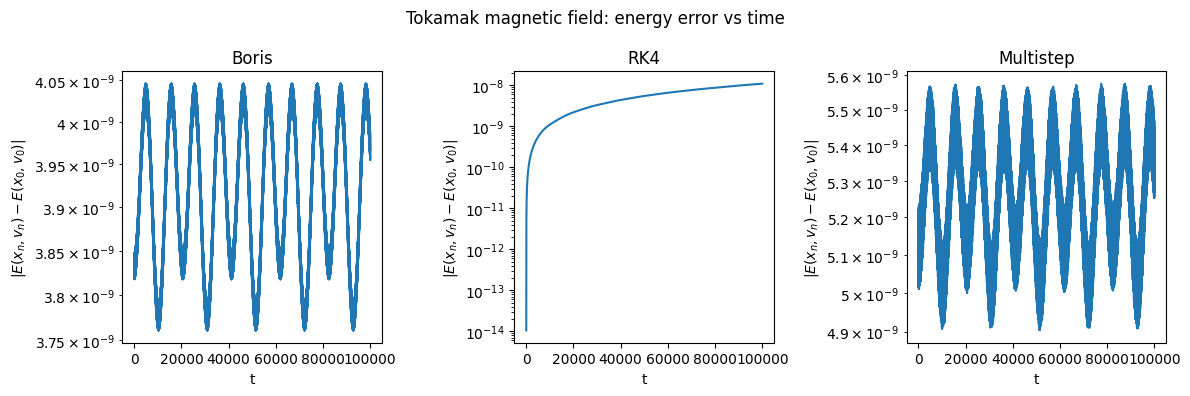

In [87]:
# 2D charged particle

# Reference energy
E_ref_1 = energy(xref1, vref1, U1)
E0_1 = E_ref_1[0]

E_boris_1 = energy(xs_boris_1, vs_boris_1, U1)
E_rk4_1 = energy(xs_rk4_1, vs_rk4_1, U1)
E_sym_1 = energy(xs_sym_1, vs_sym_1, U1)

dE_boris_1 = np.abs(E_boris_1 - E0_1)
dE_rk4_1 = np.abs(E_rk4_1 - E0_1)
dE_sym_1 = np.abs(E_sym_1 - E0_1)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Boris
axes[0].semilogy(t1[1:], dE_boris_1[1:])
axes[0].set_title("Boris")
axes[0].set_xlabel("t")
axes[0].set_ylabel(r"$|E(x_n, v_n) - E(x_0, v_0)|$")

# RK4
axes[1].semilogy(t1[1:], dE_rk4_1[1:])
axes[1].set_title("RK4")
axes[1].set_xlabel("t")
axes[1].set_ylabel(r"$|E(x_n, v_n) - E(x_0, v_0)|$")

# Multistep
axes[2].semilogy(t1[1:-1], dE_sym_1[1:-1])
axes[2].set_title("Multistep")
axes[2].set_xlabel("t")
axes[2].set_ylabel(r"$|E(x_n, v_n) - E(x_0, v_0)|$")

fig.suptitle("2D charged particle: energy error vs time")
plt.tight_layout()
plt.show()


# Tokamak magnetic field

# Reference energy
E_ref_2 = energy(xref2, vref2, U2)
E0_2 = E_ref_2[0]

E_boris_2 = energy(xs_boris_2, vs_boris_2, U2)
E_rk4_2 = energy(xs_rk4_2, vs_rk4_2, U2)
E_sym_2 = energy(xs_sym_2, vs_sym_2, U2)

dE_boris_2 = np.abs(E_boris_2 - E0_2)
dE_rk4_2 = np.abs(E_rk4_2 - E0_2)
dE_sym_2 = np.abs(E_sym_2 - E0_2)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Boris
axes[0].semilogy(t2[1:], dE_boris_2[1:])
axes[0].set_title("Boris")
axes[0].set_xlabel("t")
axes[0].set_ylabel(r"$|E(x_n, v_n) - E(x_0, v_0)|$")

# RK4
axes[1].semilogy(t2[1:], dE_rk4_2[1:])
axes[1].set_title("RK4")
axes[1].set_xlabel("t")
axes[1].set_ylabel(r"$|E(x_n, v_n) - E(x_0, v_0)|$")

# Multistep
axes[2].semilogy(t2[1:-1], dE_sym_2[1:-1])
axes[2].set_title("Multistep")
axes[2].set_xlabel("t")
axes[2].set_ylabel(r"$|E(x_n, v_n) - E(x_0, v_0)|$")

fig.suptitle("Tokamak magnetic field: energy error vs time")
plt.tight_layout()
plt.show()

# Problem A 3.

#### 2D charged particle – energy error

The first figure shows how the energy error evolves over time in the 2D charged particle system for the three methods.

- The **Boris method** exhibits bounded oscillations in the energy with a periodic pattern.  
As noted in *He et al. (2015)*, **Boris** is a volume-preserving integrator.  
It keeps the total energy confined within a small range around the true value, with reversible oscillations and no secular drift.  
The amplitude of these oscillations remains stable throughout the simulation.

- The **RK4** method shows a monotonic drift in the energy error that increases gradually with time.  
As mentioned, **RK4** is not a geometric integrator, and its small local truncation errors accumulate over long time intervals. This leads to the slow but steady growth visible in the plot, in agreement with the observations reported in *He et al. (2015)*.

- The **Multistep** method shows small oscillations with no visible long-term drift in energy.  
According to *Hairer & Lubich (2017) Figure 5.1*, symmetric multistep schemes preserve a modified energy of order $O(h^4)$ over very long times.
The energy error fluctuates but remains bounded throughout the integration.


#### Tokamak magnetic field – energy error  

The second figure shows how the energy error evolves over time in the Tokamak System for the three methods.

- The **Boris** method keeps the energy error essentially constant throughout the simulation.  
  In line with *He et al. (2015)*, its volume-preserving and time-reversible structure prevents long-term energy drift.  
  The method does not conserve the exact energy but preserves a modified invariant, causing the error to remain bounded and oscillatory.

- **RK4** follows the same qualitative pattern as in the 2D system.  
  The error starts extremely small but grows consistently over the full simulation because local energy errors accumulate in a non-geometric scheme.  
  By the end, RK4, once again, has the largest energy error.

- The **Multistep** method exhibits very similar behaviour.  
  As described in *Hairer & Lubich (2017)*, symmetric multistep schemes preserve a modified Hamiltonian over very long time intervals.  
  After the initial transient, the energy error settles into a narrow oscillatory band and remains there, achieving the smallest steady-state energy error among the three methods.


The energy errors are significantly smaller for the Tokamak system because, unlike the 2D model, the Tokamak field has no electrostatic potential ($U(x)=0$). In this case the physical energy simplifies to $E = \tfrac12 \|v\|^2$, so there is no exchange between kinetic and potential energy. Since no magnetic forces are at work, the exact dynamics preserve $\|v(t)\|$ identically, which makes the energy invariant much easier for numerical methods to reproduce.

Moreover, the Tokamak dynamics is dominated by smooth magnetic rotation. Geometric integrators such as **Boris** and the **Multistep** method approximate this rotational structure extremely well, so the modified energy remains almost constant *Hairer & Lubich (Section 6)*.

# Problem B

In [88]:
import time

def compute_reference_value(x0, v0, B, grad_U, T, rtol=1e-12, atol=1e-12):
    """
    Compute reference values x(T), v(T) using solve_ivp (RK45)
    """
    y0 = np.concatenate((x0, v0))
    sol = solve_ivp(
        lorentz_rhs,
        t_span=(0.0, T),
        y0=y0,
        t_eval=[T],
        rtol=rtol,
        atol=atol,
        args=(B, grad_U)
    )
    x_ref_T = sol.y[:3, 0]
    v_ref_T = sol.y[3:, 0]
    return x_ref_T, v_ref_T

def order_and_work_precision(
    system_name,
    x0, v0,
    B, A, U, grad_U,
    T_base=1000.0,  # shorter end-time for this experiment
    h0=0.1
):
    # step sizes h_i = h0 / 2^i, i=0,1,2
    h_vals = np.array([h0 / (2**i) for i in range(3)])

    # Store errors and times
    errors_boris = []
    errors_rk4   = []
    errors_sym   = []

    times_boris = []
    times_rk4   = []
    times_sym   = []

    for h in h_vals:
        # Align final time with step size:
        N = int(T_base / h)
        T = N * h

        # Reference solution at T
        x_ref_T, v_ref_T = compute_reference_value(x0, v0, B, grad_U, T)

        # Boris
        t0 = time.perf_counter()
        xs_boris, vs_boris = boris_integrate(x0, v0, h, N, B, grad_U)
        t1_boris = time.perf_counter()
        times_boris.append(t1_boris - t0)
        x_num_T = xs_boris[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_boris.append(err)

        # RK4
        t0 = time.perf_counter()
        xs_rk4, vs_rk4 = rk4_integrate(x0, v0, h, N, B, grad_U)
        t1_rk4 = time.perf_counter()
        times_rk4.append(t1_rk4 - t0)
        x_num_T = xs_rk4[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_rk4.append(err)

        # Multistep
        t0 = time.perf_counter()
        xs_sym = symmetric_multistep_integrate(x0, v0, h, N, A, grad_U, B)
        t1_sym = time.perf_counter()
        times_sym.append(t1_sym - t0)
        x_num_T = xs_sym[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_sym.append(err)

    # Convert to numpy arrays
    errors_boris = np.array(errors_boris)
    errors_rk4   = np.array(errors_rk4)
    errors_sym   = np.array(errors_sym)
    times_boris  = np.array(times_boris)
    times_rk4    = np.array(times_rk4)
    times_sym    = np.array(times_sym)

    # 1) Order verification plot
    plt.figure(figsize=(7, 6))
    plt.loglog(h_vals, errors_boris, "o-", label="Boris")
    plt.loglog(h_vals, errors_rk4,   "o-", label="RK4")
    plt.loglog(h_vals, errors_sym,   "o-", label="Multistep")

    # Reference lines p = 2 and p = 4
    h_ref = h_vals
    # choose constants so the lines pass near the first error point of RK4:
    C2 = errors_boris[0] / (h_vals[0]**2) if errors_boris[0] > 0 else 1.0
    C4 = errors_rk4[0]   / (h_vals[0]**4) if errors_rk4[0]   > 0 else 1.0

    plt.loglog(h_ref, C2 * h_ref**2, "--", label=r"$\mathcal{O}(h^2)$")
    plt.loglog(h_ref, C4 * h_ref**4, "--", label=r"$\mathcal{O}(h^4)$")

    plt.gca().invert_xaxis()
    plt.xlabel("h")
    plt.ylabel(r"$\|x_{\mathrm{num}}(T) - x_{\mathrm{ref}}(T)\|_2$")
    plt.title(f"{system_name}: global error vs h")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Work–precision diagram
    plt.figure(figsize=(7, 6))
    plt.loglog(times_boris, errors_boris, "o-", label="Boris")
    plt.loglog(times_rk4, errors_rk4, "o-", label="RK4")
    plt.loglog(times_sym, errors_sym,"o-", label="Multistep")

    plt.xlabel("CPU time [s]")
    plt.ylabel(r"Global error $\|x_{\mathrm{num}}(T) - x_{\mathrm{ref}}(T)\|_2$")
    plt.title(f"{system_name}: work–precision diagram")
    plt.legend()
    plt.tight_layout()
    plt.show()

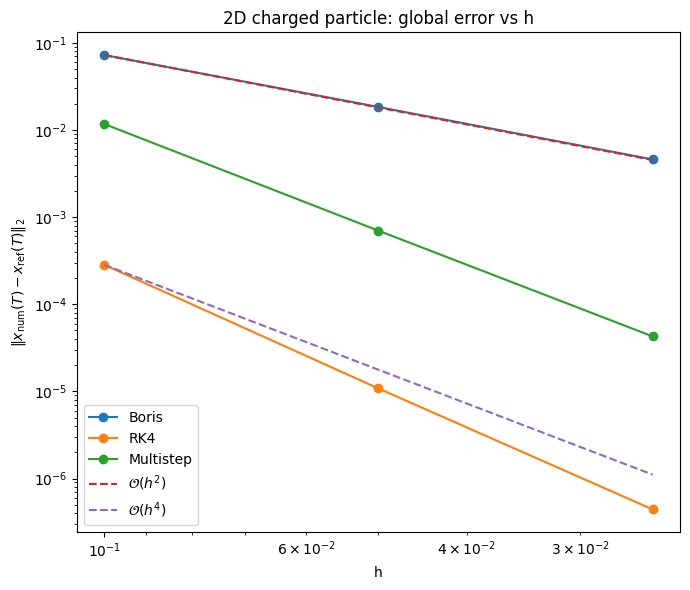

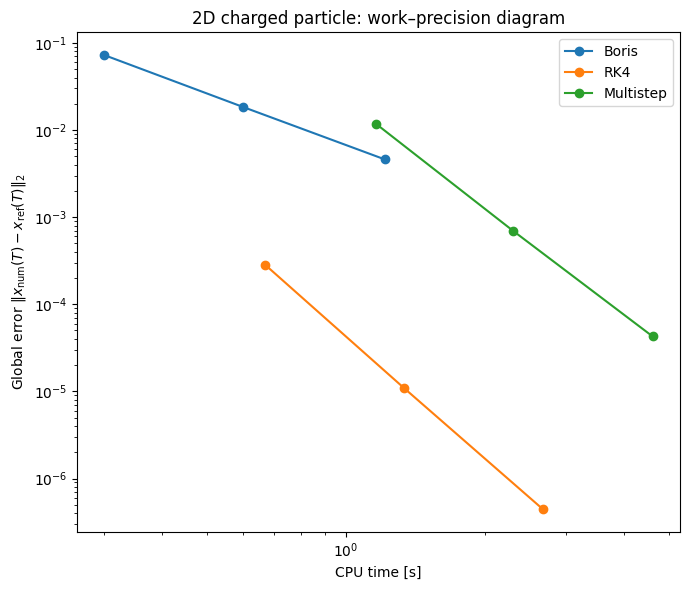

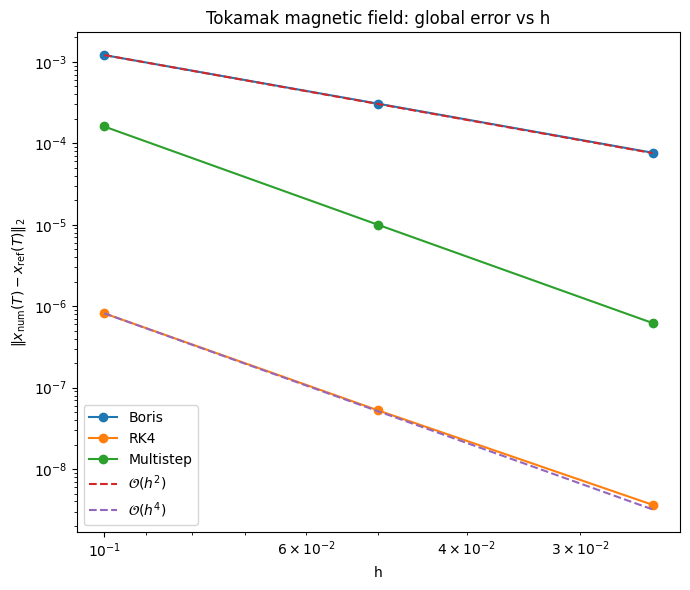

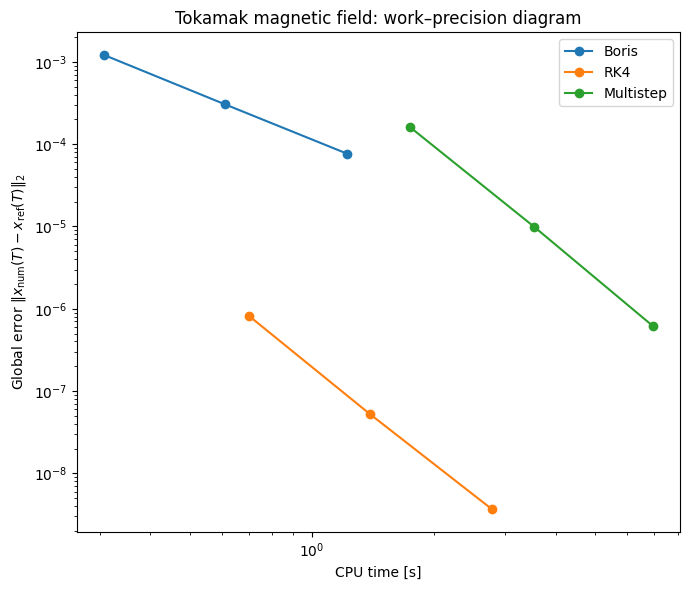

In [89]:
order_and_work_precision(
    "2D charged particle",
    x0_1, v0_1,
    B1, A1, U1, grad_U1,
    T_base=1000.0,
    h0=0.1
)

order_and_work_precision(
    "Tokamak magnetic field",
    x0_2, v0_2,
    B2, A2, U2, grad_U2,
    T_base=1000.0,
    h0=0.1
)


# Problem B.1

### Figure 1
#### 2D charged particle – global error vs. step size  

The log–log plot on the top compares the global error at a fixed final time for different step sizes $h$.  
All three schemes align well with their expected convergence orders:

- The **Boris** method follows a straight line with slope 2, consistent with a global error $O(h^2)$, confirming its  
  second-order global accuracy as described in *He et al. (2015, Section 3)*.

- The **RK4** method matches the reference slope 4 at the beginning, verifying its fourth-order global convergence. The slope appears slightly steeper in this range, which may indicate problem-dependent error cancellation and a very small error constant for this setup.

- The **Multistep** method also decays with slope 4,  
  in agreement with the theory in *Hairer & Lubich (2017)*, where the method is  
  shown to be fourth order $O(h^4)$. As expected for high-order multistep schemes, the error constant is somewhat larger than for **RK4**.


### Figure 2
#### 2D charged particle – work–precision diagram  

This figure compares the efficiency of the three methods by plotting global error against  
CPU time for various step sizes $h$.

- The **Boris** method is less accurate per unit work, consistent with its second-order nature.  
  It requires smaller step sizes to reach the accuracy of the fourth-order methods, leading to higher runtime.

- The **RK4** method is the most efficient method here: for a given accuracy it requires  
  the least CPU time. This matches the behaviour expected of a classical fourth-order one-step method with a low cost per step.

- The **Multistep** method also achieves fourth-order accuracy, but its  
  per-step cost is higher because it evaluates the vector potential and Jacobian on a wide stencil,  
  as discussed in *Hairer & Lubich (2017, Section 4)*.  
  It performs well but is less cost-effective than **RK4** in this short simulation.


### Figure 3
#### Tokamak magnetic field – global error vs. step size  

- The **Boris** method shows a clean slope 2, confirming its second-order accuracy 
in agreement with *He et al. (2015)*.

- The **RK4** method aligns with the $O(h^4)$ reference line, demonstrating its  
  fourth-order global behaviour.

- The **Multistep** method also displays fourth-order convergence,  
  consistent with the construction and analysis in *Hairer & Lubich (2017)*.  
  As before, the method has a larger error constant than **RK4**, which is typical for  
  high-order explicit multistep schemes.


### Figure 4
#### Tokamak magnetic field – work–precision diagram  

The overall behaviour matches that of the 2D system:  
**RK4** is the most efficient, the **Multistep** method is accurate but more expensive per step,  
and **Boris** requires the most computational effort for a given accuracy.

The curves are shifted downward compared to the 2D system because the computational cost per step  
differs between the two systems in our implementation.  
All methods benefit from this, but the relative ordering remains the same as in Figure 2.


# Problem C

## Exploratory exercise - Implicit Midpoint

In this exploratory part, we implemented the implicit midpoint method and examined how this second-order, time-symmetric, and symplectic integrator performs on the charged-particle systems.
Our goal was to assess its ability to preserve the particle trajectory, and compare its efficiency to the explicit methods used earlier (**Boris**, **RK4**, and **Multistep**).

### Implicit midpoint method

For a general charged-particle system  
$$
\dot{x} = v
$$
and 
$$
\dot{v} = v \times B(x) - \nabla U(x)
$$,  
the implicit midpoint method computes $(x_{n+1}, v_{n+1})$ using the midpoint values
$$ x_{\text{mid}} = (x_n + x_{n+1})/2 
$$ and
$$ v_{\text{mid}} = (v_n + v_{n+1})/2
$$ .

The update equations are
$$ x_{n+1} = x_n + h\, v_{\text{mid}}
$$  and
$$ v_{n+1} = v_n + h \,(v_{\text{mid}} \times B(x_{\text{mid}}) - \nabla U(x_{\text{mid}}))
$$.

Because the midpoint values depend on the unknown quantities at time $t_{n+1}$, each step requires solving a nonlinear fixed-point problem.  
We iterate
$$
(x_{n+1}^{(k+1)}, v_{n+1}^{(k+1)}) = F(x_{n+1}^{(k)}, v_{n+1}^{(k)}),  
$$
where $F$ is obtained by inserting the current midpoint approximations  
$$
x_{\text{mid}}^{(k)} = (x_n + x_{n+1}^{(k)})/2
$$ and  
$$
v_{\text{mid}}^{(k)} = (v_n + v_{n+1}^{(k)})/2
$$  
into the two update formulas above.

To integrate over a whole time interval, we start from initial data $(x_0, v_0)$ and apply this implicit step repeatedly:  
for $n = 0, 1, \dots, N-1$ we compute $(x_{n+1}, v_{n+1})$ from $(x_n, v_n)$ with the midpoint rule.  
This produces sequences $\{x_n\}_{n=0}^N$ and $\{v_n\}_{n=0}^N$ that approximate the full trajectory in phase space.


In [90]:
# Implicit midpoint step

def implicit_midpoint_step(x_n, v_n, h, B, grad_U, tol=1e-10, max_iter=100):
    """
    Implicit midpoint step
    x_{n+1} = x_n + h * v( (t_n + t_{n+1})/2 )
    v_{n+1} = v_n + h * ( v_mid x B(x_mid) - grad_U(x_mid))
    """
    x_np1 = x_n.copy()
    v_np1 = v_n.copy()

    for _ in range(max_iter):
        x_mid = 0.5 * (x_n + x_np1)
        v_mid = 0.5 * (v_n + v_np1)

        x_new = x_n + h * v_mid
        v_new = v_n + h * (np.cross(v_mid, B(x_mid)) - grad_U(x_mid))

        # Convergence check
        if (np.linalg.norm(x_new - x_np1) < tol and
                np.linalg.norm(v_new - v_np1) < tol):
            x_np1, v_np1 = x_new, v_new
            break

        x_np1, v_np1 = x_new, v_new

    return x_np1, v_np1


def implicit_midpoint_integrate(x0, v0, h, N, B, grad_U, tol=1e-10, max_iter=100):
    """
    Integrate with the implicit midpoint method
    """
    xs = np.zeros((N + 1, 3))
    vs = np.zeros((N + 1, 3))

    xs[0] = x0
    vs[0] = v0

    for n in range(N):
        xs[n + 1], vs[n + 1] = implicit_midpoint_step(
            xs[n], vs[n], h, B, grad_U, tol=tol, max_iter=max_iter
        )

    return xs, vs

In [91]:
# Implicit midpoint method

# 2D charged particle
xs_imp_1, vs_imp_1 = implicit_midpoint_integrate(x0_1, v0_1, h, N, B1, grad_U1)

# Tokamak magnetic field
xs_imp_2, vs_imp_2 = implicit_midpoint_integrate(x0_2, v0_2, h, N, B2, grad_U2)

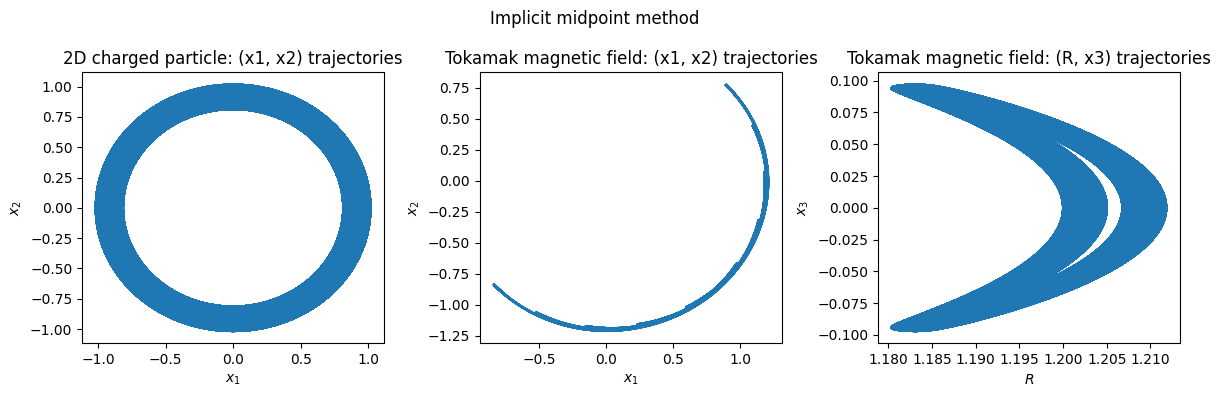

In [92]:
# Implicit method plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(xs_imp_1[:, 0], xs_imp_1[:, 1])
axes[0].set_title("2D charged particle: (x1, x2) trajectories")
axes[0].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")

axes[1].plot(xs_imp_2[:, 0], xs_imp_2[:, 1])
axes[1].set_title("Tokamak magnetic field: (x1, x2) trajectories")
axes[1].set_xlabel(r"$x_1$")
axes[1].set_ylabel(r"$x_2$")

# Tokamak magnetic field: banana orbit in $(R,x_3)$
R_boris_2 = np.sqrt(xs_imp_2[:, 0]**2 + xs_imp_2[:, 1]**2)

axes[2].plot(R_boris_2, xs_imp_2[:, 2])
axes[2].set_title("Tokamak magnetic field: (R, x3) trajectories")
axes[2].set_xlabel(r"$R$")
axes[2].set_ylabel(r"$x_3$")

fig.suptitle("Implicit midpoint method")
plt.tight_layout()
plt.show()


#### Implicit Midpoint – trajectories  

The $(x_1, x_2)$-trajectories are the same as for the previous methods in both systems.  
We also observe the same banana orbit in the $(R, x_3)$-trajectory.  
This shows that the implicit midpoint method preserves the overall structure of the motion very well.  
This is exactly what we expect from a symplectic integrator, and it matches the behaviour seen for the other structure-preserving methods.


In [93]:
import time

# Adding the implicit midpoint as a method to our previous verification and work-precision function

def order_and_work_precision_with_implicit(
    system_name,
    x0, v0,
    B, A, U, grad_U,
    T_base=1000.0,
    h0=0.1
):
    # step sizes h_i = h0 / 2^i, i=0,1,2
    h_vals = np.array([h0 / (2**i) for i in range(3)])

    errors_boris = []
    errors_rk4   = []
    errors_sym   = []
    errors_imp   = []

    times_boris = []
    times_rk4   = []
    times_sym   = []
    times_imp   = []

    for h in h_vals:
        N = int(T_base / h)
        T = N * h

        # Reference solution at T
        x_ref_T, v_ref_T = compute_reference_value(x0, v0, B, grad_U, T)

        # Boris
        t0 = time.perf_counter()
        xs_boris, vs_boris = boris_integrate(x0, v0, h, N, B, grad_U)
        t1_boris = time.perf_counter()
        times_boris.append(t1_boris - t0)
        x_num_T = xs_boris[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_boris.append(err)

        # RK4
        t0 = time.perf_counter()
        xs_rk4, vs_rk4 = rk4_integrate(x0, v0, h, N, B, grad_U)
        t1_rk4 = time.perf_counter()
        times_rk4.append(t1_rk4 - t0)
        x_num_T = xs_rk4[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_rk4.append(err)

        # Multistep
        t0 = time.perf_counter()
        xs_sym = symmetric_multistep_integrate(x0, v0, h, N, A, grad_U, B)
        t1_sym = time.perf_counter()
        times_sym.append(t1_sym - t0)
        x_num_T = xs_sym[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_sym.append(err)

        # Implicit midpoint
        t0 = time.perf_counter()
        xs_imp, vs_imp = implicit_midpoint_integrate(x0, v0, h, N, B, grad_U)
        t1_imp = time.perf_counter()
        times_imp.append(t1_imp - t0)
        x_num_T = xs_imp[-1]
        err = np.linalg.norm(x_num_T - x_ref_T)
        errors_imp.append(err)

    errors_boris = np.array(errors_boris)
    errors_rk4   = np.array(errors_rk4)
    errors_sym   = np.array(errors_sym)
    errors_imp   = np.array(errors_imp)

    times_boris  = np.array(times_boris)
    times_rk4    = np.array(times_rk4)
    times_sym    = np.array(times_sym)
    times_imp    = np.array(times_imp)

    # 1) Order verification plot
    plt.figure(figsize=(7, 6))
    plt.loglog(h_vals, errors_boris, "o-", label="Boris")
    plt.loglog(h_vals, errors_rk4,   "o-", label="RK4")
    plt.loglog(h_vals, errors_sym,   "o-", label="Multistep")
    plt.loglog(h_vals, errors_imp,   "o-", label="Implicit midpoint")

    h_ref = h_vals
    C2 = errors_boris[0] / (h_vals[0]**2) if errors_boris[0] > 0 else 1.0
    C4 = errors_rk4[0]   / (h_vals[0]**4) if errors_rk4[0]   > 0 else 1.0

    plt.loglog(h_ref, C2 * h_ref**2, "--", label=r"$\mathcal{O}(h^2)$")
    plt.loglog(h_ref, C4 * h_ref**4, "--", label=r"$\mathcal{O}(h^4)$")

    plt.gca().invert_xaxis()
    plt.xlabel("h")
    plt.ylabel(r"$\|x_{\mathrm{num}}(T) - x_{\mathrm{ref}}(T)\|_2$")
    plt.title(f"{system_name}: global error vs h")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Work–precision diagram
    plt.figure(figsize=(7, 6))
    plt.loglog(times_boris, errors_boris, "o-", label="Boris")
    plt.loglog(times_rk4,   errors_rk4,   "o-", label="RK4")
    plt.loglog(times_sym,   errors_sym,   "o-", label="Midpoint")
    plt.loglog(times_imp,   errors_imp,   "o-", label="Implicit midpoint")

    plt.xlabel("CPU time [s]")
    plt.ylabel(r"Global error $\|x_{\mathrm{num}}(T) - x_{\mathrm{ref}}(T)\|_2$")
    plt.title(f"{system_name}: work–precision diagram")
    plt.legend()
    plt.tight_layout()
    plt.show()


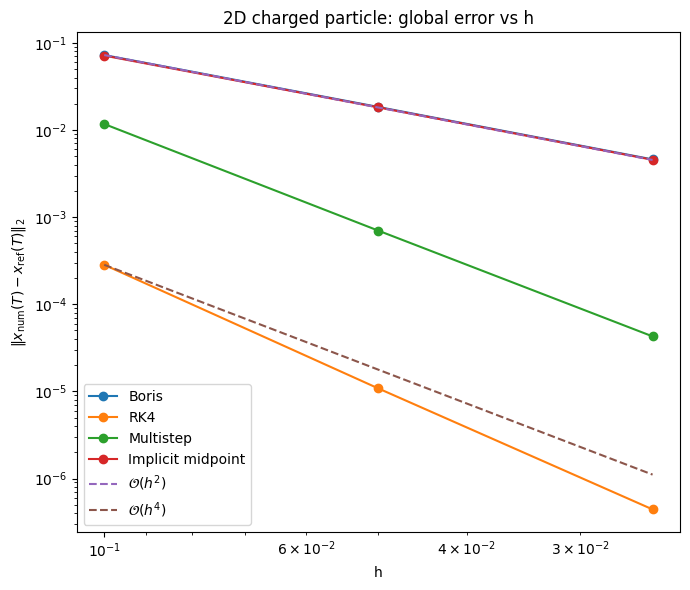

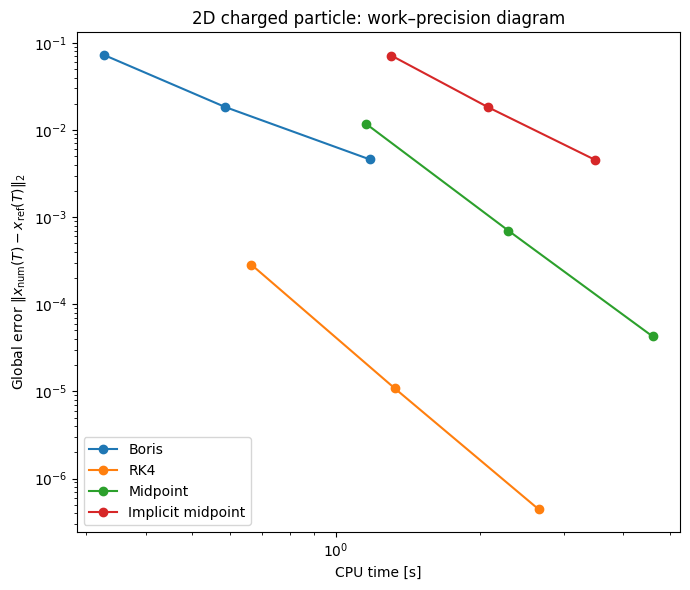

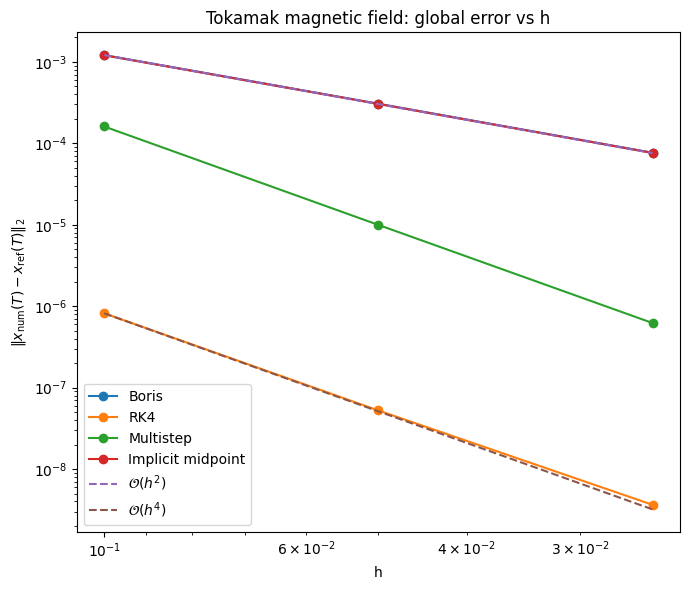

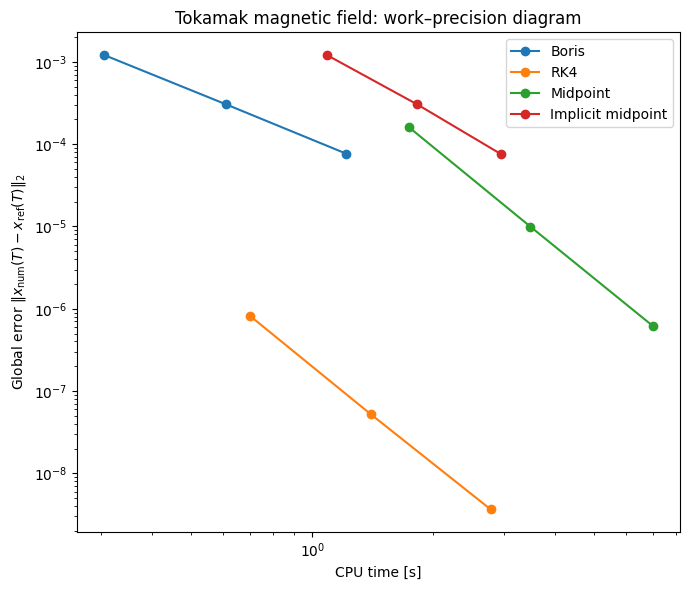

In [94]:
results_implicit_sys1 = order_and_work_precision_with_implicit(
    "2D charged particle",
    x0_1, v0_1,
    B1, A1, U1, grad_U1,
    T_base=1000.0,
    h0=0.1
)

results_implicit_sys2 = order_and_work_precision_with_implicit(
    "Tokamak magnetic field",
    x0_2, v0_2,
    B2, A2, U2, grad_U2,
    T_base=1000.0,
    h0=0.1
)


### Implicit Midpoint – order verification and work–precision  

The order verification confirms that the implicit midpoint method follows the expected second-order convergence rate for both systems.  
Its slope aligns cleanly with the $O(h^2)$ reference line and matches the behaviour described earlier for second-order geometric schemes.

In the work–precision diagram, the implicit midpoint method achieves smaller error than **Boris** for the same step size, but it is clearly slower than **RK4** and **Multistep** for comparable accuracy.  
This is expected: each step requires solving an implicit equation, which increases the computational cost even though the method itself is very stable.

### Discussion  
Overall, the results are consistent with expectations.  
The implicit midpoint method shows second-order accuracy and is less efficient than the explicit methods for moderate step sizes, but it offers strong long-term stability and robustness for stiff or highly oscillatory problems. This method behaves as theory predicts, slightly slower, but very
stable and reliable. It was a good way to explore how an implicit, structure-preserving approach compares to the explicit methods used earlier.